In [80]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.QuadOptimizer.multi_plane_fast import MultiplaneFast
from lenstronomy.LensModel.QuadOptimizer.param_manager import PowerLawFreeShear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pylab as pylab
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import Planck15

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [16]:
SNR = 5.098 # known from original fits file
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
im[im < 0] = 0

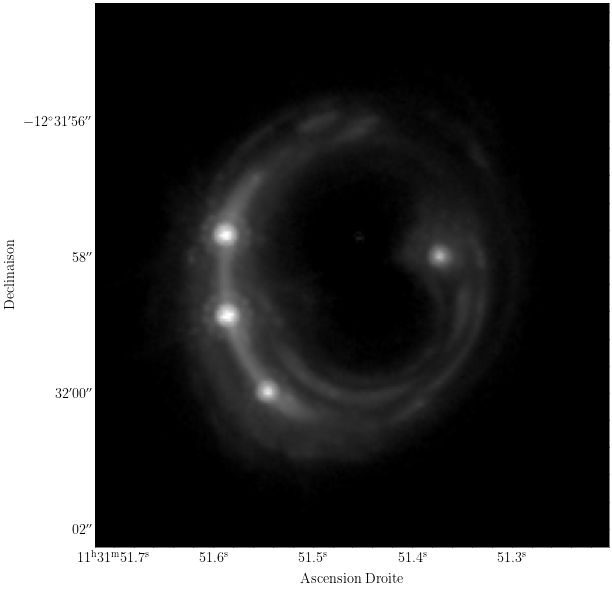

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [35]:
# Trouver la position des 4 images principales
mean, median, std = sigma_clipped_stats(im,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
image_principales = daofind(im).to_pandas().sort_values("flux", ascending=False).iloc[:4]
image_principales

0.017546648 0.0 0.034847353


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
13,14,47.630071,114.149930,0.421323,-0.140638,-0.164836,25,0.0,123.906906,604.727832,-6.953900
8,9,48.316470,84.484198,0.459638,0.277774,-0.305937,25,0.0,121.668182,503.413541,-6.754812
3,4,63.115152,56.540868,0.687271,0.069577,0.076066,25,0.0,65.747673,269.003839,-6.074396
12,13,126.250540,106.427980,0.665696,0.205851,0.011222,25,0.0,17.827728,72.637033,-4.652895


In [54]:
# make a pixel grid and find center pixel
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M * N // 2]).to(u.arcsec)

In [59]:
x_image = image_principales["xcentroid"].to_numpy()
y_image = image_principales["ycentroid"].to_numpy()
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - x_center).to(u.arcsec)
y_image = (positions.dec - y_center).to(u.arcsec)

In [90]:
z_lens = 0.295
z_source = 0.654
# lens_model = LensModel(["SPEMD"])
params = [{
    "theta_E": 1.6,
    "gamma": 2,
    "e1": 0.4,
    "e2": 0,
    "s_scale": 0.1,
    "center_x": 0,
    "center_y": 0
     }]
optim = MultiplaneFast(x_image, y_image, z_lens, z_source, ["SPEMD"], [z_lens], Planck15, PowerLawFreeShear(params[0]), None)
optim.logL(params)

TypeError: unhashable type: 'slice'

dict_values([1.6, 2, 0.4, 0, 0.1, 0, 0])